In [1]:
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
batch_size = 64
width, height, channel = 400, 400, 3
epochs = 10
input_shape = (width, height, channel)

In [3]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None
)

In [4]:
pretrained_model.trainable = False

model = Sequential()

for layer in pretrained_model.layers[:-1]:
    model.add(layer)

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)     2

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory('preprocessed_data/train',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = datagen.flow_from_directory('preprocessed_data/test',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs = epochs
                   )

Found 2603 images belonging to 2 classes.
Found 650 images belonging to 2 classes.
Epoch 1/10
41/41 [==============================] - 29s 710ms/step - loss: 0.8513 - auc: 0.5923 - accuracy: 0.5509 - val_loss: 0.5762 - val_auc: 0.7907 - val_accuracy: 0.6877
Epoch 2/10
41/41 [==============================] - 27s 662ms/step - loss: 0.5304 - auc: 0.8502 - accuracy: 0.7726 - val_loss: 0.4571 - val_auc: 0.8955 - val_accuracy: 0.8108
Epoch 3/10
41/41 [==============================] - 27s 661ms/step - loss: 0.4628 - auc: 0.8770 - accuracy: 0.7987 - val_loss: 0.3907 - val_auc: 0.9283 - val_accuracy: 0.8400
Epoch 4/10
41/41 [==============================] - 27s 658ms/step - loss: 0.4019 - auc: 0.9101 - accuracy: 0.8271 - val_loss: 0.3467 - val_auc: 0.9362 - val_accuracy: 0.8415
Epoch 5/10
41/41 [==============================] - 27s 669ms/step - loss: 0.3779 - auc: 0.9148 - accuracy: 0.8360 - val_loss: 0.3390 - val_auc: 0.9313 - val_accuracy: 0.8431
Epoch 6/10
41/41 [========================

In [20]:
# https://dryjelly.tistory.com/147

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output(valid_generator[0][0])
class_weights = model.layers[-1].get_weights()[0]


output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(25*25,1024))))
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

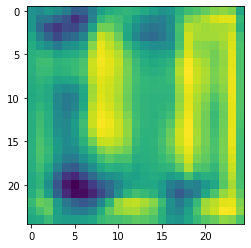

In [15]:
plt.imshow(np.reshape(output[0][0], (25, 25)))

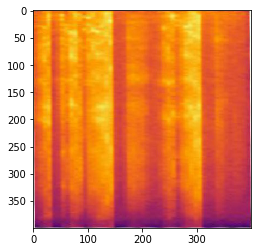

In [16]:
plt.imshow(valid_generator[0][0][0])